In [1]:
%cd ..

c:\Workspace\Projects\diffusion-planning-rl


c:\Users\roloz\miniconda3\envs\env-dprl\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload
%autoreload 2

import torch
import glob
import os
import sys
from hydra import compose, initialize
import hydra
from omegaconf import OmegaConf, SCMode

from lightning import Fabric
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


from dprl.data.utils import dotdict
from dprl.algo.seq2seq import LatentDFModel
from dprl.algo.autoencoder import CategoricalAutoEncoder
from dprl.data.datasets import LiberoDatasetAdapter
from dprl.data.utils import AtariTransform


In [3]:
try:
    initialize(version_base=None, config_path="../dprl/config")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="../dprl/config")

cfg = compose(config_name="config", overrides=["algo=diffusion_M_categorical"])
cfg = dotdict(OmegaConf.to_container(cfg, resolve=True, structured_config_mode=SCMode.DICT_CONFIG))

In [4]:
model_path = "forced_diffusion_M"

fabric = Fabric(accelerator='gpu', precision="bf16-mixed")

def get_last_checkpoint(model_path : str):
    checkpoints = glob.glob(f"checkpoints/{model_path}/*.ckp")
    checkpoint = max(checkpoints, key=os.path.getctime)
    
    model_params = torch.load(checkpoint, weights_only=True)['model']
    
    ae : CategoricalAutoEncoder = CategoricalAutoEncoder.from_config(fabric, cfg.algo, need_optim=False)
    
    model : LatentDFModel = LatentDFModel.from_config(fabric, cfg.algo, encoder=ae.encoder, decoder=ae.decoder, action_model=ae.action_model)
    model.load_state_dict(model_params)
    
    return model
    
model = get_last_checkpoint(model_path)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 4080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [7]:
transform = AtariTransform(
        to_size=cfg.algo.encoder.in_shape[1:],
        swap_channels=True,
        num_channels=3,
        augment=False
    )

dataset = LiberoDatasetAdapter("Datasets/libero_spatial",
                                slice_len=50,
                                transform=transform,
                                frameskip=1
                                )

In [8]:
def show_obs(y : torch.Tensor, frameskip : int = 10):
    if len(y.shape) == 5:
        y = y[0]
    
    y = y.cpu()
    
    trajectory_images = make_grid(y[::frameskip].flip(2), nrow=50//frameskip)
    trajectory_images = trajectory_images * 0.5 + 0.5
    
    plt.figure(figsize=(20, 2))
    plt.imshow(trajectory_images.permute(1, 2, 0))

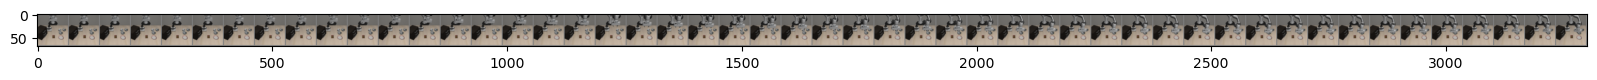

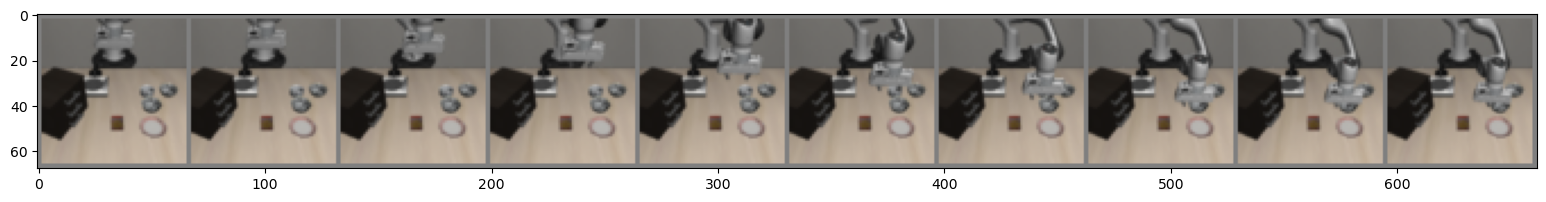

In [9]:
obs = dataset[0]['observations']
act = dataset[0]['actions'][:-1, :]

show_obs(obs, frameskip=1)
show_obs(obs, frameskip=5)

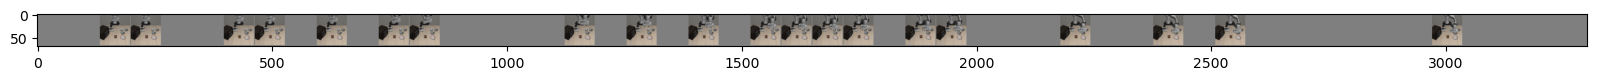

In [10]:
mask = torch.rand((obs.shape[0])) < 0.5 
show_obs(obs * mask[:, None, None, None], frameskip=1)

In [ ]:
# You can reduce the amount of sampling timesteps if needed
model.diffusion.sampling_timesteps = 10

# THIS IS THE IMPORTANT PART
# FEED IN A (B, T, C, H, W) shape, as well as the number of future frames to simulate
# This will return the action prediction for the next frame only

print(dataset[0]['observations'].shape)
with torch.no_grad():
    x_pred = model.sample(dataset[0]['observations'][None, :5].to(fabric.device), 10)

torch.Size([50, 3, 64, 64])
5 10


100%|██████████| 100/100 [00:01<00:00, 57.98it/s]


In [37]:
x_pred

tensor([ 0.7596, -0.1428, -0.0827,  0.0207,  0.0960, -0.3537, -1.0000],
       device='cuda:0')

In [27]:
x_pred.shape

torch.Size([1, 15, 512])

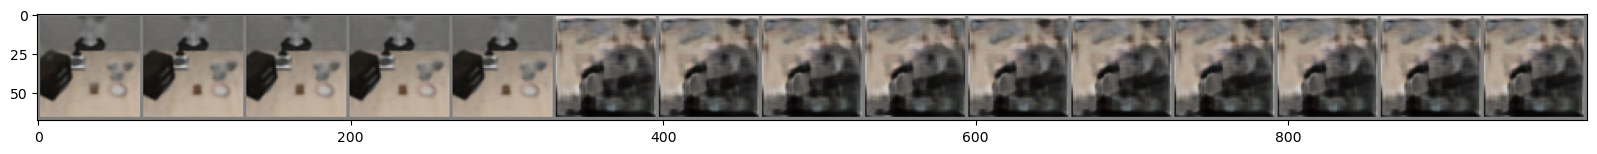

In [25]:
show_obs(x_pred[0], frameskip=1)

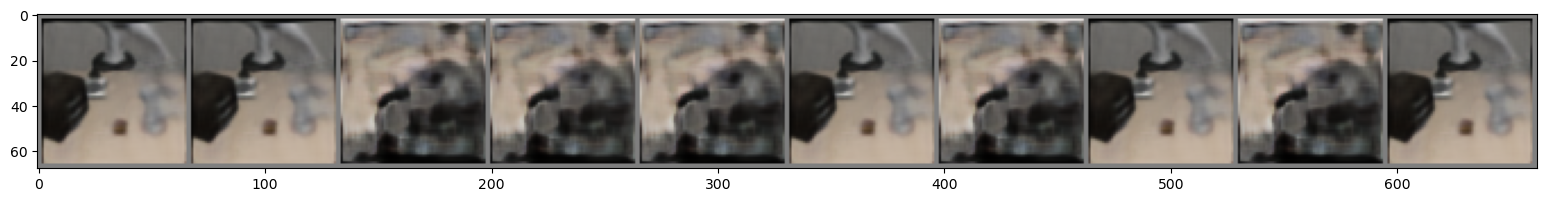

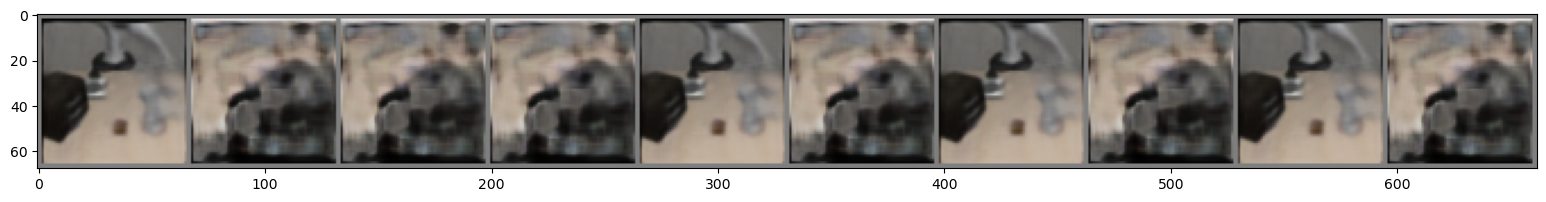

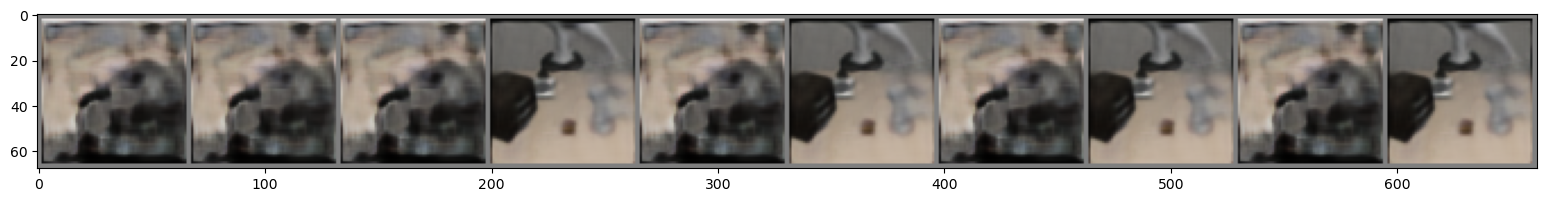

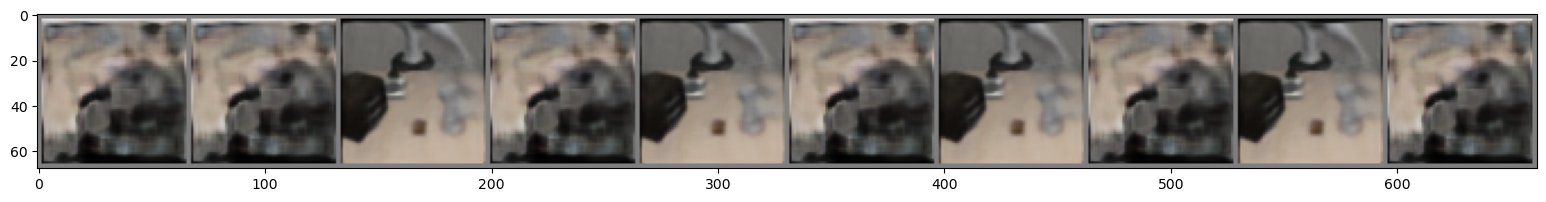

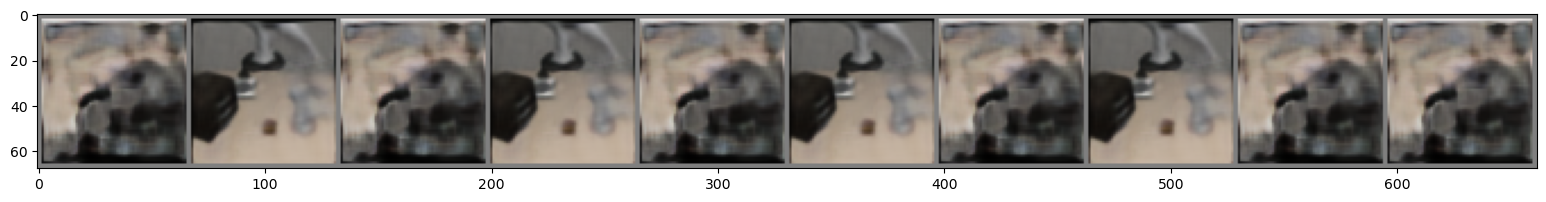

In [ ]:
for i in range(5):
    show_obs(x_pred[0, i:i+10], frameskip=1)

In [ ]:
z_pred = latents[-1]

In [ ]:
with torch.no_grad():
    B, T, E = z_pred.shape

    z_pred = torch.as_strided(z_pred, size=(B, T - 1, E * 2), stride=(T * E, E, 1))
    action_predictions : torch.distributions.Normal = model.action_model(z_pred)


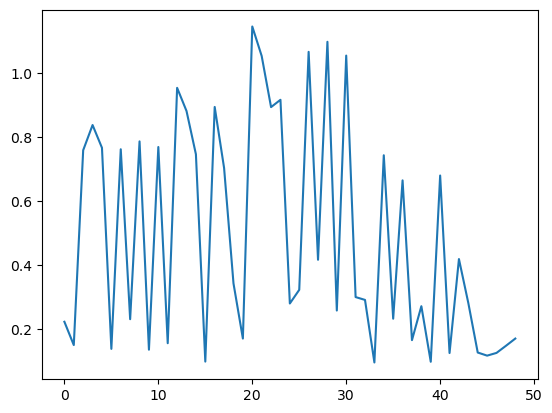

In [34]:
plt.plot(((act - action_predictions.mean[0].cpu()) ** 2).mean(-1))

Action planning kinda iffy...

In [35]:
action_predictions.mean

tensor([[[-0.0456,  0.0353, -0.2266, -0.0190, -0.0193, -0.0096,  0.2049],
         [ 0.7493, -0.4343, -0.3521,  0.2421,  0.0707, -0.3838, -0.9999],
         [ 0.8234, -0.6443,  0.4208, -0.1997, -0.1892, -0.4549,  1.0000],
         [ 0.8505, -0.6677, -0.1109, -0.0831, -0.4871, -0.6193,  1.0000],
         [ 0.8647, -0.6179,  0.5506, -0.0474,  0.0263, -0.4113,  1.0000],
         [ 0.7782, -0.2830, -0.1091,  0.2239,  0.0289, -0.3946, -0.9321],
         [ 0.8209, -0.4219,  0.4891, -0.0556,  0.0265, -0.3768,  1.0000],
         [ 0.7082, -0.3335, -0.6754,  0.3327,  0.0753, -0.3689, -0.9993],
         [ 0.8025, -0.5396,  0.1326, -0.0782, -0.1099, -0.3993,  1.0000],
         [ 0.7726, -0.1528, -0.4213,  0.0900,  0.0101, -0.4108, -0.9997],
         [ 0.8543, -0.4009,  0.3492, -0.0093,  0.0981, -0.3756,  1.0000],
         [ 0.8270, -0.2905, -0.0603,  0.1087,  0.0996, -0.4637, -0.9998],
         [ 0.8987, -0.7128,  0.5568, -0.1182, -0.3111, -0.5346,  1.0000],
         [ 0.7392, -0.6210,  0.1934, -